# Deep Learning Option Pricing

Solving the Black-Scholes Partial Differential Equation (PDE), using Physics Informed Neural Networks (PINNs), which governs the price of European options and can be derived from basic principles of hedging, risk neutrality, and no-arbitrage.

Based on following papers:

- "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations" by Maziar Raissi, Paris Perdikaris, and George Em Karniadakis [Link: https://arxiv.org/abs/1711.10561].
- "Physics Informed Neural Network for Option Pricing" by Ashish Dhiman and Yibei Hu [Link: https://arxiv.org/html/2312.06711v1].

The code is inspired by the github repository of Alireza Afzal Afhaei
- [Link: https://github.com/alirezaafzalaghaei/PINN-tutorial]
- [Link: https://github.com/keonly/black-scholes-pinn]
- [Link: https://github.com/alialaradi/DeepGalerkinMethod]
- [Link: https://github.com/rujuldwivedi/Quant-Models]

## Key Assumptions of the Black-Scholes Model:

### 1. Geometric Brownian Motion:
The underlying asset price $S(t)$ follows a stochastic process modeled by:

$$dS(t) = \mu S(t) dt + \sigma S(t) dW(t)$$

where:
- $\mu$ is the drift rate (expected return of the asset).
- $\sigma$ is the volatility of the asset.
- $W(t)$ is a Wiener process (standard Brownian motion).

### 2. No Arbitrage:
There are no arbitrage opportunities in the market, meaning prices adjust to eliminate riskless profit opportunities.

### 3. Constant Interest Rate:
The risk-free interest rate $r$ is constant over time.

## Step 1: Setting Up a Portfolio

We construct a portfolio $\Pi$ consisting of:
- A long position in one option (value $C(S, t)$).
- A short position in $\Delta$ units of the underlying asset $S(t)$, where $\Delta$ is the hedge ratio (the option's delta).

The value of this portfolio is:

$$\Pi = C(S, t) - \Delta S(t)$$

To make the portfolio riskless (i.e., no exposure to the stochastic changes in $S$), we choose $\Delta$ to cancel out the stochastic part of the option's value, such that:

$$d\Pi = dC - \Delta dS$$

From **Ito's Lemma**, the differential of the option price $C(S, t)$ is given by:

$$dC = \frac{\partial C}{\partial t} dt + \frac{\partial C}{\partial S} dS + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2S^2dt$$

Substituting the stochastic process for $dS(t)$, we get:

$$dC = \frac{\partial C}{\partial t} dt + \frac{\partial C}{\partial S} (\mu S dt + \sigma S dW) + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 dt$$

Now, choosing $\Delta = \frac{\partial C}{\partial S}$ (i.e., delta hedging), the stochastic terms involving $dW$ cancel out, leaving us with:

$$d\Pi = \frac{\partial C}{\partial t} dt + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 dt$$

Since this portfolio is riskless, by the principle of no arbitrage, it must earn the risk-free rate $r$. Therefore, the portfolio's value $\Pi$ must satisfy:

$$d\Pi = r \Pi dt$$

Substituting the value of: $$\Pi = C(S, t) - \Delta S = C(S, t) - \frac{\partial C}{\partial S} S$$

We get:

$$\frac{\partial C}{\partial t} + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 + rS \frac{\partial C}{\partial S} - rC = 0$$

This is the **Black-Scholes Partial Differential Equation**.

## Step 2: Boundary Conditions

For a European call option, the boundary conditions are:

- **At maturity** $t = T$, the option payoff is given by:
  
$$C(S, T) = \max(S_T - X, 0)$$

where $X$ is the strike price.

## Problem Statement

We have been given a PDE:
$$
\dfrac{\partial C}{\partial t} + \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 C}{\partial S^2} + rS\dfrac{\partial C}{\partial S} -rC = 0
$$

and boundary conditions:
$$
\begin{align*}
   &C(t, 0) = 0 &&\text{for all $t \geq 0$}\\
   &C(t, S) \to S - K &&\text{for all $t \geq 0$ as $S \to \infty$}\\
   &C(T, S) = \max\{S - K, 0\}
\end{align*}
$$

- Independent variables: $t, S$ (input)
- Dependent variables: $C$ (outputs)

# DEEP GALERKIN METHOD

## Import needed packages

In [34]:
import tensorflow as tf
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

## LSTM-like layer used in DGM

In [71]:
class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1="tanh", trans2="tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.sigmoid
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_weight("Uz", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Ug = self.add_weight("Ug", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Ur = self.add_weight("Ur", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Uh = self.add_weight("Uh", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_weight("Wz", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Wg = self.add_weight("Wg", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Wr = self.add_weight("Wr", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Wh = self.add_weight("Wh", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        
        # bias vectors
        self.bz = self.add_weight("bz", shape=[1, self.output_dim])
        self.bg = self.add_weight("bg", shape=[1, self.output_dim])
        self.br = self.add_weight("br", shape=[1, self.output_dim])
        self.bh = self.add_weight("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X, self.Uz), tf.matmul(S, self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X, self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X, self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X, self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z, S))
        
        return S_new

## Fully connected (dense) layer

In [72]:
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_weight("W", shape=[self.input_dim, self.output_dim],
                                  initializer=tf.keras.initializers.GlorotNormal())
        
        # bias vectors
        self.b = self.add_weight("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    # main function to be called 
    def call(self, X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

## Neural network architecture used in DGM

In [73]:
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spatial dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet, self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim + 1, transformation="tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim + 1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation=final_trans)
    
    # main function to be called  
    def call(self, t, x):
        '''            
        Args:
            t: sampled time inputs 
            x: sampled space inputs

        Run the DGM model and obtain fitted function value at the inputs (t,x)                 
        '''  
        
        # define input vector as time-space pairs
        X = tf.concat([t, x], 1)
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S, X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result

## Parameters 

In [85]:
# Option parameters
r = 0.05           # Interest rate
sigma = 0.3        # Volatility
K = 100            # Strike
T = 1.5            # Terminal time (reduced to focus on shorter-term behaviors)
S0 = 0.5           # Initial price

# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10  # time lower bound
S_low = 0.0 + 1e-10  # spot price lower bound
S_high = 3 * K       # spot price upper bound (reduce from 4*K to 3*K)

# neural network parameters
num_layers = 4     # Increase number of layers from 3 to 4
nodes_per_layer = 100  # Increase number of neurons per layer from 50 to 100
learning_rate = 0.0001  # Keep learning rate

# Training parameters
sampling_stages  = 200   # Increase sampling stages from 100 to 200
steps_per_sample = 20    # Increase SGD steps per sample to 20

# Sampling parameters
nSim_interior = 2000     # Increase the number of interior points to 2000
nSim_terminal = 200      # Increase terminal condition points to 200
S_multiplier  = 1.2      # Reduce oversampling to 1.2 instead of 1.5

# Plot options
n_plot = 100  # Increase plot resolution to 100 points

# Save options
saveOutput = True
saveName   = 'BlackScholes_EuropeanCall'
saveFigure = True
figureName = 'BlackScholes_EuropeanCall.png'


## Black-Scholes European call price

In [86]:
def BlackScholesCall(S, K, r, sigma, t):
    ''' Analytical solution for European call option price under Black-Scholes model 
    
    Args:
        S:     spot price
        K:     strike price
        r:     risk-free interest rate
        sigma: volatility
        t:     time
    ''' 
    epsilon = 1e-10
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * (T-t + epsilon)) / (sigma * np.sqrt(T-t + epsilon))

    d2 = d1 - (sigma * np.sqrt(T-t))
    callPrice = S * spstats.norm.cdf(d1) - K * np.exp(-r * (T-t)) * spstats.norm.cdf(d2)
    
    return callPrice

## Sampling function - randomly sample time-space pairs 

In [87]:
def sampler(nSim_interior, nSim_terminal):
    ''' Sample time-space points from the function's domain
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    S_interior = np.random.uniform(low=S_low, high=S_high * S_multiplier, size=[nSim_interior, 1])

    t_terminal = T * np.ones((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high * S_multiplier, size=[nSim_terminal, 1])
    
    return t_interior, S_interior, t_terminal, S_terminal

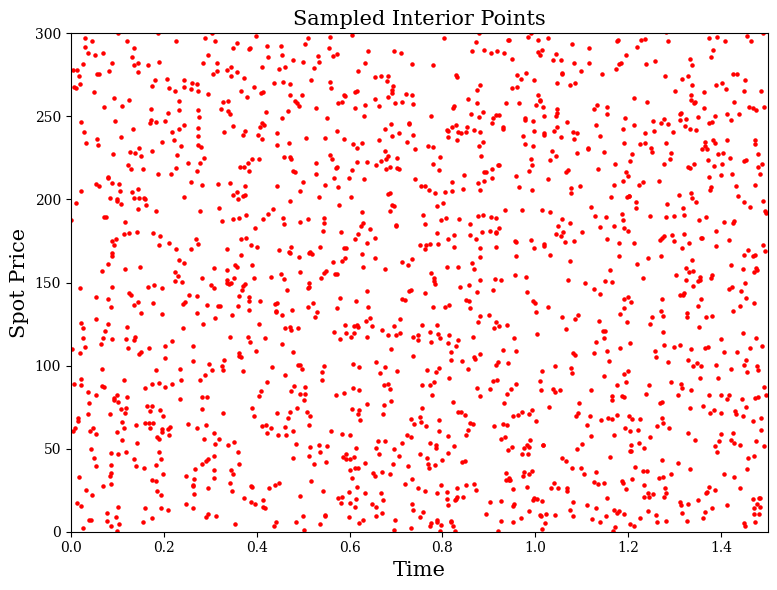

In [89]:
# Plotting the sampled points

t_interior, S_interior, t_terminal, S_terminal = sampler(nSim_interior, nSim_terminal)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(t_interior, S_interior, color='r', s=5)
plt.xlim([t_low, T])
plt.ylim([S_low, S_high])
plt.title('Sampled Interior Points', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Spot Price', fontsize=15)

plt.tight_layout()
if saveFigure: plt.savefig('sampled_points.png')
plt.show()

## Loss function for Fokker-Planck equation

In [90]:
@tf.function
def loss(model, t_interior, S_interior, t_terminal, S_terminal):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    ''' 
    with tf.GradientTape(persistent=True) as tape:
        V = model(t_interior, S_interior)
        V_t = tape.gradient(V, t_interior)
        V_s = tape.gradient(V, S_interior)
        V_ss = tape.gradient(V_s, S_interior)

        diff_V = V_t + 0.5 * sigma**2 * S_interior**2 * V_ss + r * S_interior * V_s - r * V
        L1 = tf.reduce_mean(tf.square(diff_V))
        
        target_payoff = tf.nn.relu(S_terminal - K)
        fitted_payoff = model(t_terminal, S_terminal)
        L3 = tf.reduce_mean(tf.square(fitted_payoff - target_payoff))
    
    return L1, L3

## Set up network

In [91]:
model = DGMNet(nodes_per_layer, num_layers, 1)

# optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

## Training step function

In [92]:
@tf.function
def train_step(t_interior, S_interior, t_terminal, S_terminal):
    # Calculate the total loss and backpropagate the gradients
    with tf.GradientTape() as tape:
        L1, L3 = loss(model, t_interior, S_interior, t_terminal, S_terminal)
        total_loss = L1 + L3
    
    # Compute the gradients of the loss w.r.t. model's trainable variables
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # Apply gradients using the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, L1, L3

## Train network

In [93]:
@tf.function
def loss(model, t_interior, S_interior, t_terminal, S_terminal):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    ''' 
    with tf.GradientTape(persistent=True) as tape:
        # Watch both t_interior and S_interior for gradient computation
        tape.watch(t_interior)
        tape.watch(S_interior)
        
        # Compute model predictions
        V = model(t_interior, S_interior)
        
        # Compute gradients w.r.t. time and space
        V_t = tape.gradient(V, t_interior)
        V_s = tape.gradient(V, S_interior)
        V_ss = tape.gradient(V_s, S_interior)

    # Debugging: Ensure gradients are valid
    if V_t is None:
        raise ValueError("Gradient w.r.t. time is None. Check your model and inputs.")
    if V_s is None:
        raise ValueError("Gradient w.r.t. space is None. Check your model and inputs.")
    if V_ss is None:
        raise ValueError("Second-order space gradient is None. Check your model and inputs.")
    
    # Black-Scholes PDE residual
    diff_V = V_t + 0.5 * sigma**2 * S_interior**2 * V_ss + r * S_interior * V_s - r * V
    
    # PDE loss (L1)
    L1 = tf.reduce_mean(tf.square(diff_V))
    
    # Terminal boundary condition loss (L3)
    target_payoff = tf.nn.relu(S_terminal - K)
    fitted_payoff = model(t_terminal, S_terminal)
    L3 = tf.reduce_mean(tf.square(fitted_payoff - target_payoff))
    
    return L1, L3


In [94]:
# Train the model

# Ensure variables are created outside the tf.function decorated function
for i in range(sampling_stages):
    # Sample interior and terminal points
    t_interior, S_interior, t_terminal, S_terminal = sampler(nSim_interior, nSim_terminal)
    
    # Cast the sampled data to float32 for compatibility with the model
    t_interior = tf.cast(t_interior, dtype=tf.float32)
    S_interior = tf.cast(S_interior, dtype=tf.float32)
    t_terminal = tf.cast(t_terminal, dtype=tf.float32)
    S_terminal = tf.cast(S_terminal, dtype=tf.float32)
    
    # Perform multiple training steps per sampling stage
    for _ in range(steps_per_sample):
        total_loss, L1, L3 = train_step(t_interior, S_interior, t_terminal, S_terminal)
        print(f"Total loss: {total_loss:.5f}, PDE loss: {L1:.5f}, Boundary loss: {L3:.5f}")


Total loss: 14830.55078, PDE loss: 0.41158, Boundary loss: 14830.13965
Total loss: 14798.47070, PDE loss: 0.40542, Boundary loss: 14798.06543
Total loss: 14766.39355, PDE loss: 0.39849, Boundary loss: 14765.99512
Total loss: 14734.41797, PDE loss: 0.39090, Boundary loss: 14734.02734
Total loss: 14702.65137, PDE loss: 0.38328, Boundary loss: 14702.26855
Total loss: 14671.20117, PDE loss: 0.37636, Boundary loss: 14670.82520
Total loss: 14640.16504, PDE loss: 0.37049, Boundary loss: 14639.79492
Total loss: 14609.62109, PDE loss: 0.36572, Boundary loss: 14609.25586
Total loss: 14579.61230, PDE loss: 0.36187, Boundary loss: 14579.25000
Total loss: 14550.12305, PDE loss: 0.35867, Boundary loss: 14549.76465
Total loss: 14521.11035, PDE loss: 0.35576, Boundary loss: 14520.75488
Total loss: 14492.49023, PDE loss: 0.35276, Boundary loss: 14492.13770
Total loss: 14464.20215, PDE loss: 0.34939, Boundary loss: 14463.85254
Total loss: 14436.19434, PDE loss: 0.34548, Boundary loss: 14435.84863
Total 

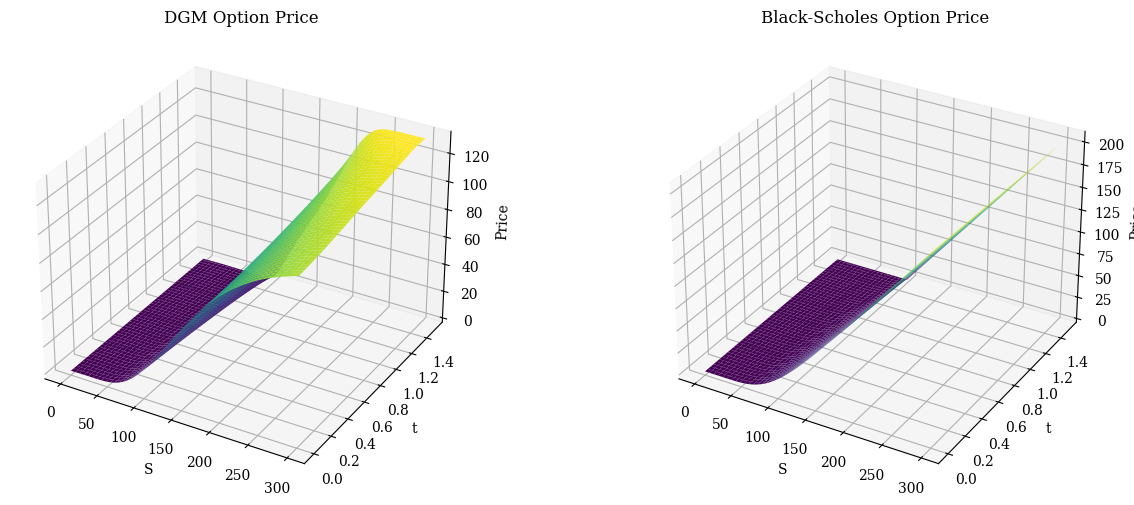

In [95]:
# Plot the option price surface

S_plot = np.linspace(S_low, S_high, n_plot)
t_plot = np.linspace(t_low, T, n_plot)

S_grid, t_grid = np.meshgrid(S_plot, t_plot)

# Compute option price using the trained model
price = model(t_grid.reshape(-1, 1), S_grid.reshape(-1, 1)).numpy().reshape(n_plot, n_plot)

# Compute Black-Scholes price
price_bs = np.zeros_like(price)
for i in range(n_plot):
    for j in range(n_plot):
        price_bs[i, j] = BlackScholesCall(S_plot[j], K, r, sigma, t_plot[i])

# Plotting
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Option price
ax1.plot_surface(S_grid, t_grid, price, cmap='viridis')
ax1.set_title('DGM Option Price')
ax1.set_xlabel('S')
ax1.set_ylabel('t')
ax1.set_zlabel('Price')

# Black-Scholes price
ax2.plot_surface(S_grid, t_grid, price_bs, cmap='viridis')
ax2.set_title('Black-Scholes Option Price')
ax2.set_xlabel('S')
ax2.set_ylabel('t')
ax2.set_zlabel('Price')

# Save the figure if necessary
if saveFigure:
    plt.savefig(figureName)
plt.show()

# Save the model output
if saveOutput:
    model.save_weights('./SavedNets/' + saveName)


## Plot results

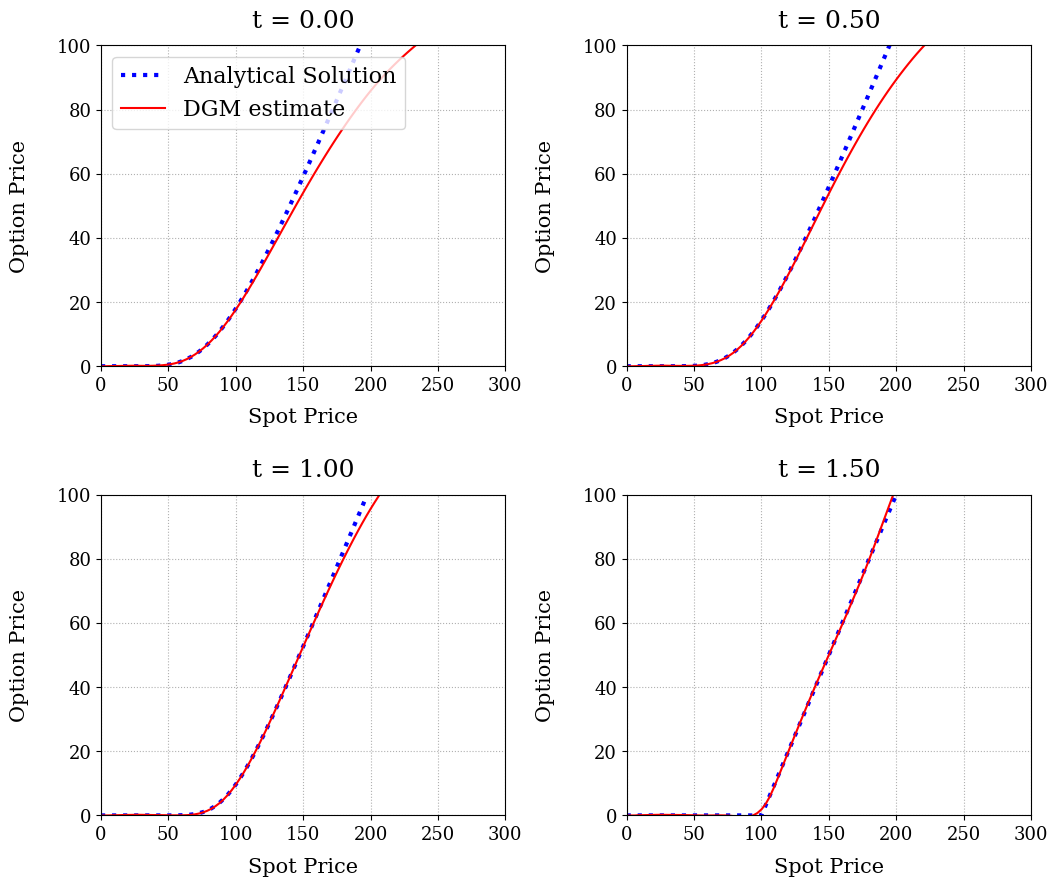

In [96]:
# Disable LaTeX rendering in matplotlib
plt.rcParams['text.usetex'] = False

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# You can still use custom fonts without LaTeX, so we retain the serif font setting.
plt.rc('font', family='serif')

# Create the figure
plt.figure(figsize=(12, 10))

# Define time values and spot prices for plotting
valueTimes = [t_low, T/3, 2*T/3, T]
S_plot = np.linspace(S_low, S_high, n_plot)

for i, curr_t in enumerate(valueTimes):
    plt.subplot(2, 2, i + 1)
    
    # Calculate the analytical and estimated option values
    optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    t_plot = curr_t * np.ones_like(S_plot.reshape(-1, 1))
    fitted_optionValue = model(tf.convert_to_tensor(t_plot, dtype=tf.float32), tf.convert_to_tensor(S_plot.reshape(-1, 1), dtype=tf.float32))
    
    # Plot the analytical and estimated values
    plt.plot(S_plot, optionValue, color='b', label='Analytical Solution', linewidth=3, linestyle=':')
    plt.plot(S_plot, fitted_optionValue.numpy(), color='r', label='DGM estimate')    
    
    # Set plot limits and labels
    plt.ylim(ymin=0.0, ymax=K)
    plt.xlim(xmin=0.0, xmax=S_high)
    plt.xlabel("Spot Price", fontsize=15, labelpad=10)
    plt.ylabel("Option Price", fontsize=15, labelpad=20)
    plt.title(f"t = {curr_t:.2f}", fontsize=18, y=1.03)
    
    # Set font sizes for ticks and add grid lines
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(linestyle=':')
    
    # Add a legend for the first subplot
    if i == 0:
        plt.legend(loc='upper left', prop={'size': 16})
    
# Adjust subplot spacing
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Save the figure if needed
if saveFigure:
    plt.savefig(figureName)
